# **THAT IS AN ATTEMPT TO FIT DECODER-ONLY TRANSFORMER FOR TIME SERIES PREDICTION, IT IS NOT RELATED TO COMPETITION!!!**

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Fix random seed for reproducibility
seed_everything(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class SineWaveDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples, seq_len, noise_std=0.0):
        self.seq_len = seq_len
        x = np.linspace(0, 4 * np.pi, num_samples)  # Time steps
        y = np.sin(x) + noise_std * np.random.randn(num_samples)  # Sine wave with noise

        self.data = []
        self.targets = []
        for i in range(len(y) - seq_len - 1):
            seq = y[i:i+seq_len+1]  # Absolute sequence
            next_seq = y[i+2:i+seq_len+2]  # Target sequence

            relative_seq = seq[1:] - seq[:-1]  # Convert to relative differences
            relative_target = next_seq - seq[-1]  # Target as difference from last value

            self.data.append(relative_seq)
            self.targets.append(relative_target)

        self.data = torch.tensor(self.data, dtype=torch.float32).unsqueeze(-1)  # Shape: (samples, seq_len, 1)
        self.targets = torch.tensor(self.targets, dtype=torch.float32).unsqueeze(-1)  # Shape: (samples, seq_len, 1)
    
    def normalize(self):
        a = self.targets.mean()
        b = self.targets.std()
        self.data = (self.data - a) / b
        self.targets = (self.targets - a) / b
        return a, b

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Parameters
num_samples = 1000
seq_len = 512
batch_size = 16

# Create dataset and dataloaders
dataset = SineWaveDataset(num_samples, seq_len)
a, b = dataset.normalize()
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

/tmp/ipykernel_2566284/569406462.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  self.data = torch.tensor(self.data, dtype=torch.float32).unsqueeze(-1)  # Shape: (samples, seq_len, 1)


In [3]:
class TransformerDecoderOnly(nn.Module):
    def __init__(self, input_dim, d_model, num_layers, nhead, dim_feedforward, dropout, seq_len):
        super().__init__()
        self.seq_len = seq_len
        self.embedding = nn.Linear(input_dim, d_model)  # Input projection
        self.positional_encoding = nn.Parameter(torch.randn(1, seq_len, d_model))  # Learnable Positional Encoding

        # Transformer decoder layers
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        # Final output layer
        self.output_layer = nn.Linear(d_model, input_dim)

    def forward(self, tgt):
        tgt = self.embedding(tgt) + self.positional_encoding
        tgt = tgt.permute(1, 0, 2)  # Shape: (seq_len, batch, d_model)

        # Causal mask to prevent looking ahead
        mask = nn.Transformer.generate_square_subsequent_mask(self.seq_len).to(tgt.device)

        # Transformer decoder forward pass
        output = self.decoder(tgt, tgt, tgt_mask=mask)
        return self.output_layer(output.permute(1, 0, 2))  # Back to (batch, seq_len, input_dim)

# Model Hyperparameters
input_dim = 1
d_model = 32
num_layers = 8
nhead = 2
dim_feedforward = 256
dropout = 0.1

# Initialize model
model = TransformerDecoderOnly(input_dim, d_model, num_layers, nhead, dim_feedforward, dropout, seq_len).to(device)
sum([p.numel() for p in model.parameters()])

218977

In [4]:
# Training loop
epochs = 100

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
sceduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs * len(train_loader), 1e-6)

for epoch in range(epochs):
    for (x_batch, y_batch) in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        output = model(y_batch)  # Decoder-only takes only target input
        loss = criterion(output, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        sceduler.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.39323386549949646
Epoch 10, Loss: 0.036791685968637466
Epoch 20, Loss: 0.017119254916906357
Epoch 30, Loss: 0.010888750664889812
Epoch 40, Loss: 0.007062674965709448
Epoch 50, Loss: 0.006063250359147787
Epoch 60, Loss: 0.00631920387968421
Epoch 70, Loss: 0.006274410989135504
Epoch 80, Loss: 0.004376978147774935
Epoch 90, Loss: 0.005686288233846426


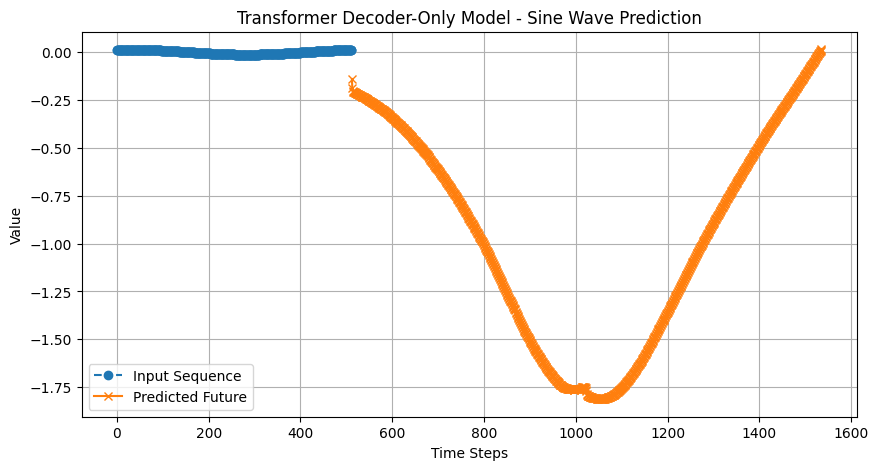

In [10]:
def predict(model, seed_sequence, prediction_horizon):
    model.eval()
    with torch.no_grad():
        input_seq = seed_sequence.clone().to(device)
        predictions = []
        last_absolute_value = 0#input_seq[:, -1:, :]

        for _ in range(prediction_horizon):
            output = model(input_seq)  # Predict next step difference
            delta = output[:, -1:, :]  # Get last step prediction

            # Compute actual next value
            next_value = last_absolute_value + delta  # Restore absolute value
            predictions.append(next_value)

            # Shift input sequence
            input_seq = torch.cat([input_seq[:, 1:, :], delta], dim=1)

            # Update last absolute value
            # last_absolute_value = next_value

        return torch.cat(predictions, dim=1)  # Concatenate predictions

# Select a random test sample
seed_seq, _ = next(iter(test_loader))  # Get one batch (batch=1)
predicted_series = predict(model, seed_seq, prediction_horizon=1024)

# Convert tensors to numpy arrays for plotting
seed_seq_np = seed_seq.squeeze().numpy()
predicted_series_np = predicted_series.cpu().squeeze().numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(range(seq_len), seed_seq_np, label="Input Sequence", marker='o', linestyle="dashed")
plt.plot(range(seq_len, seq_len + 1024), predicted_series_np, label="Predicted Future", marker='x')
# plt.plot(range(1024), predicted_series_np, label="Predicted Future", marker='x')
plt.legend()
plt.title("Transformer Decoder-Only Model - Sine Wave Prediction")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.grid()
plt.show()